In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.optim as optim
from tensorflow.keras.callbacks import EarlyStopping
from itertools import cycle


In [7]:
url = "https://raw.githubusercontent.com/farrelrassya/teachingMLDL/main/02.%20Deep%20Learning/Dataset/compressed_data.csv.gz"
data = pd.read_csv(url, compression='gzip')


In [8]:
X = data.drop('Cover_Type', axis=1)
y = data['Cover_Type'] - 1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()


In [9]:
X_train_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test_tf = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train_tf = tf.convert_to_tensor(y_train, dtype=tf.int32)
y_test_tf = tf.convert_to_tensor(y_test, dtype=tf.int32)

inputs = tf.keras.Input(shape=(X_train.shape[1], ))
hid = tf.keras.layers.Dense(256, activation='relu')(inputs)
hid = tf.keras.layers.Dense(128, activation='relu')(hid)
hid = tf.keras.layers.Dense(64, activation='relu')(hid)
outputs = tf.keras.layers.Dense(7, activation='softmax')(hid)

tf_model = tf.keras.Model(inputs, outputs)

earlystop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

tf_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

tf_model.fit(X_train, y_train, validation_split=0.15, batch_size=128, epochs=50, callbacks=[earlystop])


Epoch 1/50
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7423 - loss: 0.6128 - val_accuracy: 0.8183 - val_loss: 0.4301
Epoch 2/50
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8281 - loss: 0.4066 - val_accuracy: 0.8545 - val_loss: 0.3531
Epoch 3/50
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8571 - loss: 0.3431 - val_accuracy: 0.8687 - val_loss: 0.3140
Epoch 4/50
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8745 - loss: 0.3046 - val_accuracy: 0.8799 - val_loss: 0.2945
Epoch 5/50
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8848 - loss: 0.2794 - val_accuracy: 0.8897 - val_loss: 0.2714
Epoch 6/50
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8931 - loss: 0.2613 - val_accuracy: 0.8973 - val_loss: 0.2579
Epoch 7/50
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8988 - loss: 0.2480 - val_accuracy: 0.8997 - val_loss: 0.2479
Epoch 8/50
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9023 - loss: 0.2

In [10]:
y_pred_probs = tf_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

def evaluate_model(y_true, y_pred, y_pred_probs):
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_true, y_pred_probs, multi_class='ovr')
    cm = confusion_matrix(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print("\nConfusion Matrix:\n", cm)

evaluate_model(y_test, y_pred, y_pred_probs)


3632/3632 ━━━━━━━━━━━━━━━━━━━━ 3s 766us/step
Accuracy: 0.9237
Precision: 0.9239
Recall: 0.9237
F1-score: 0.9238
ROC AUC: 0.9948

Confusion Matrix:
 [[39262  2761     5     0    44    13   283]
 [ 3227 52643   174     0   375   182    60]
 [    1   151  6625    78    14   282     0]
 [    0     0    52   483     0    14     0]
 [   45   270    32     0  1541    11     0]
 [    8   106   396    42     3  2918     0]
 [  224    17     0     0     0     0  3861]]


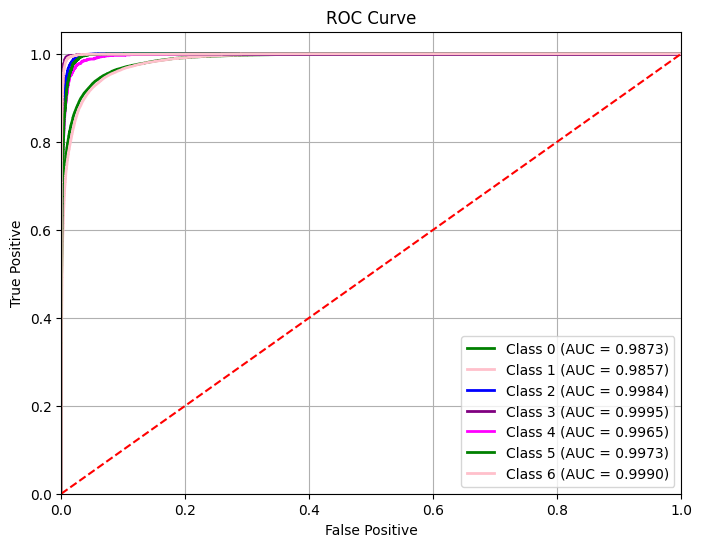

In [11]:
y_pred_probs = y_pred_probs / np.sum(y_pred_probs, axis=1, keepdims=True)
n_classes = y_pred_probs.shape[1]
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))

colors = cycle(['green', 'pink', 'blue', 'purple', 'magenta'])

plt.figure(figsize=(8, 6))

for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, label=f'Class {i} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [12]:
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.long)
y_test_torch = torch.tensor(y_test, dtype=torch.long)

class PyNeuNet(nn.Module):
    def __init__(self):
        super(PyNeuNet, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.out = nn.Linear(64, 7)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.out(x)
        return x

t_model = PyNeuNet()
optimizer = optim.Adam(t_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
train_dataset = TensorDataset(X_train_torch, y_train_torch)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

epochs = 15
for epoch in range(epochs):
    t_model.train()
    total_loss = 0
    for batch_idx, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = t_model(x)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    if epoch % 2 == 0:
        print(f'Epoch: {epoch+1}, Average Loss: {avg_loss:.4f}')


Epoch: 1, Average Loss: 0.5424
Epoch: 3, Average Loss: 0.3498
Epoch: 5, Average Loss: 0.2870
Epoch: 7, Average Loss: 0.2534
Epoch: 9, Average Loss: 0.2325
Epoch: 11, Average Loss: 0.2163
Epoch: 13, Average Loss: 0.2048
Epoch: 15, Average Loss: 0.1955


In [13]:
t_model.eval()
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.long)

test_dataset = TensorDataset(X_test_torch, y_test_torch)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

y_pred_probs = []
y_actual = []

with torch.no_grad():
    for x, target in test_loader:
        output = t_model(x)
        probabilities = F.softmax(output, dim=1).numpy()
        y_pred_probs.extend(probabilities)
        y_actual.extend(target.numpy())

y_pred = np.argmax(y_pred_probs, axis=1)
tensor_accuracy = accuracy_score(y_actual, y_pred)
tensor_precision = precision_score(y_actual, y_pred, average='weighted')
tensor_recall = recall_score(y_actual, y_pred, average='weighted')
tensor_f1 = f1_score(y_actual, y_pred, average='weighted')
tensor_roc = roc_auc_score(label_binarize(y_actual, classes=np.arange(7)), y_pred_probs, multi_class='ovr')

print(f"Accuracy: {tensor_accuracy}")
print(f"Precision: {tensor_precision}")
print(f"Recall: {tensor_recall}")
print(f"F1-score: {tensor_f1}")
print(f"ROC AUC: {tensor_roc}")


Accuracy: 0.9178506579003984
Precision: 0.9180350914137407
Recall: 0.9178506579003984
F1-score: 0.9178133909131977
ROC AUC: 0.9942216715602223


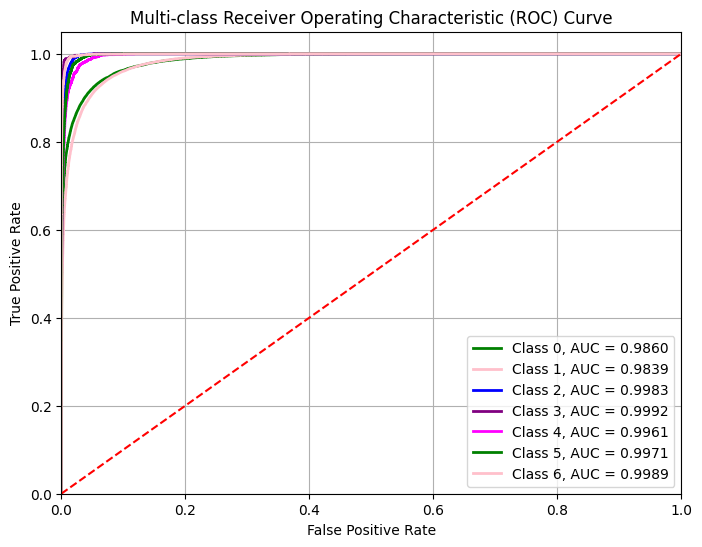

In [14]:
y_pred_probs = y_pred_probs / np.sum(y_pred_probs, axis=1, keepdims=True)
n_classes = y_pred_probs.shape[1]
y_test_bin = label_binarize(y_actual, classes=np.arange(n_classes))
colors = cycle(['green', 'pink', 'blue', 'purple', 'magenta'])

plt.figure(figsize=(8, 6))

for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, label=f'Class {i}, AUC = {roc_auc:.4f}')

plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()
